# Tensorflow Data Analysis Example

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import tensorflow as tf
import tickDataProcessing as TDP
import os

In [2]:
Path = "dataPackages/rawdata"
tradeDays = []
for root, dirs, files in os.walk(Path):
    for _dir in dirs:
        tradeDays.append(Path + '/' + _dir + '/')

### get sample data

In [3]:
totalStocks = 10
Path = tradeDays[0]
X_sample, Y_sample = TDP.geneTrainingData_shuffle(Path, skip = 16, length = totalStocks)

In [4]:
print(X_sample.shape)
print(Y_sample.shape)

(10, 30, 21)
(10, 30)


prepare traning data and labels

In [5]:
def formatting(X, Y):
    X = X.transpose((1,0,2))
    n = len(Y)
    Y = pd.DataFrame(Y).rank() / n
    Y = Y.values.transpose()
    Y = np.reshape(Y, [len(Y), n, 1])
    if len(X) == len(Y):
        return X, Y
    else:
        print("Unmatched size of X and Y !!!")

In [6]:
X_train, Y_train = formatting(X_sample, Y_sample)

In [7]:
print(X_train.shape)
print(Y_train.shape)

(30, 10, 21)
(30, 10, 1)


### Graph

In [8]:
sess = tf.Session()
x = tf.placeholder(tf.float32, [None, totalStocks, 21])
y = tf.placeholder(tf.float32, [None, totalStocks, 1])
nodeLayout = [40, 30, 20, 10]
internalDropout = tf.placeholder(tf.float32, None)
net = x
dropout = 0.5
with tf.name_scope('network'):
    layerPos = 0
    for units in nodeLayout:
        net = tf.layers.dense(net, units=units, activation=tf.nn.tanh, name=str("dense" + str(layerPos)))
        net = tf.layers.dropout(net, rate = internalDropout)
        layerPos += 1
logits = tf.layers.dense(net, 1, activation=tf.nn.sigmoid)

In [9]:
with tf.name_scope('lossFunction'):
    square_loss = tf.losses.mean_squared_error(predictions=logits, labels=y)

In [10]:
learningRate = .001
with tf.name_scope("trainingStep"):
    tf.summary.scalar('squareLoss', square_loss)
    trainStep = tf.train.AdamOptimizer(learningRate).minimize(square_loss)

In [11]:
init = tf.global_variables_initializer()
sess.run(init)

### Run

In [12]:
print(len(tradeDays))

23


In [13]:
_rank = np.random.choice(tradeDays, len(tradeDays), replace = False)
days_train = _rank[0:18]
days_test = _rank[18:]
print(days_train)
print(days_test)

['dataPackages/rawdata/20/' 'dataPackages/rawdata/03/'
 'dataPackages/rawdata/31/' 'dataPackages/rawdata/23/'
 'dataPackages/rawdata/27/' 'dataPackages/rawdata/07/'
 'dataPackages/rawdata/13/' 'dataPackages/rawdata/10/'
 'dataPackages/rawdata/30/' 'dataPackages/rawdata/02/'
 'dataPackages/rawdata/06/' 'dataPackages/rawdata/17/'
 'dataPackages/rawdata/01/' 'dataPackages/rawdata/16/'
 'dataPackages/rawdata/09/' 'dataPackages/rawdata/08/'
 'dataPackages/rawdata/14/' 'dataPackages/rawdata/15/']
['dataPackages/rawdata/24/' 'dataPackages/rawdata/29/'
 'dataPackages/rawdata/22/' 'dataPackages/rawdata/21/'
 'dataPackages/rawdata/28/']


In [14]:
import time
from matplotlib import pyplot as plt

In [15]:
epochs = 50
batchSize = 5
InSampleResult = []
OutSampleResult = []
startTime = time.time()
for epoch in range(epochs):
    trainError = 0.0
    _iterTrain = 0
    for _path in days_train:
        X_sample, Y_sample = TDP.geneTrainingData_shuffle(Path, skip = 16, length = totalStocks)
        try:
            X, Y = formatting(X_sample, Y_sample)
        except:
            continue
        for i in np.arange(0, len(X) - batchSize + 1):
            j = np.arange(i, i + batchSize)
            x_feeds = X[j]
            y_feeds = Y[j]
            training, _trainError = sess.run([trainStep, square_loss], 
                                             feed_dict = {x: x_feeds, y:y_feeds, internalDropout: dropout})
        trainError += _trainError
        _iterTrain += 1
    InSampleResult.append(trainError / _iterTrain)
    testError = 0.0
    _iterTest = 0
    for _path in days_test:
        X_sample, Y_sample = TDP.geneTrainingData_shuffle(Path, skip = 16, length = totalStocks)
        try:
            X, Y = formatting(X_sample, Y_sample)
        except:
            continue
        for i in np.arange(0, len(X) - batchSize + 1):
            j = np.arange(i, i + batchSize)
            x_feeds = X[j]
            y_feeds = Y[j]
            testError += sess.run(square_loss, feed_dict = {x: x_feeds, y:y_feeds, internalDropout: dropout})
        _iterTest += 1
    OutSampleResult.append(testError / _iterTest)
    print("epoch %d: training error %.5f, testing error %.5f" %(epoch + 1, trainError / _iterTrain, testError / _iterTest))
print("Finished, time consume: %.2f" %(time.time() - startTime))

epoch 1: training error 0.06813, testing error 0.77200
epoch 2: training error 0.02531, testing error 0.25713
epoch 3: training error 0.01637, testing error 0.10304
epoch 4: training error 0.00963, testing error 0.20846
epoch 5: training error 0.00767, testing error 0.09389
epoch 6: training error 0.00562, testing error 0.07722
epoch 7: training error 0.00366, testing error 0.07359
epoch 8: training error 0.00247, testing error 0.05776
epoch 9: training error 0.00253, testing error 0.08127
epoch 10: training error 0.00239, testing error 0.05803
epoch 11: training error 0.00211, testing error 0.02252
epoch 12: training error 0.00134, testing error 0.05187
epoch 13: training error 0.00154, testing error 0.05635
epoch 14: training error 0.00142, testing error 0.03667
epoch 15: training error 0.00110, testing error 0.05250
epoch 16: training error 0.00127, testing error 0.04157
epoch 17: training error 0.00112, testing error 0.03341
epoch 18: training error 0.00138, testing error 0.04041
e

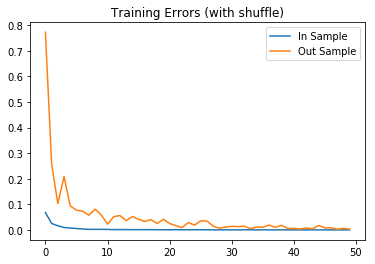

In [16]:
plt.plot(InSampleResult, label = 'In Sample')
plt.plot(OutSampleResult, label = 'Out Sample')
plt.legend()
plt.title("Training Errors (with shuffle)")
plt.show()

In [17]:
saver = tf.train.Saver()
saver.save(sess, 'models/tf_pred03')

'models/tf_pred03'

## Records

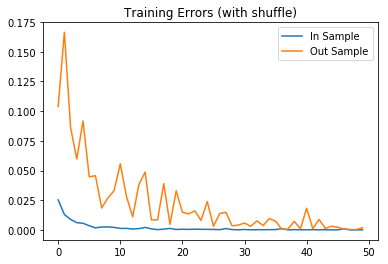

In [19]:
plt.plot(InSampleResult, label = 'In Sample')
plt.plot(OutSampleResult, label = 'Out Sample')
plt.legend()
plt.title("Training Errors (with shuffle)")
plt.show()

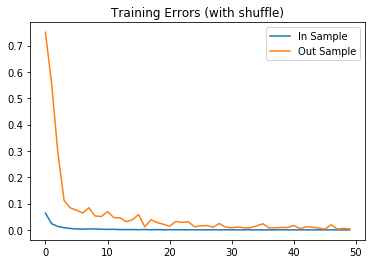

In [16]:
plt.plot(InSampleResult, label = 'In Sample')
plt.plot(OutSampleResult, label = 'Out Sample')
plt.legend()
plt.title("Training Errors (with shuffle)")
plt.show()